In [80]:
# all necessary imports here
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2, make_scorer


import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns


In [2]:
#Data Collection
#Not sure why I had two separate files, but whoopdidoodie
ticker = 'AAPL'
df = pd.read_csv(f'{ticker}_Data.csv')
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume
0,2024-11-29,234.810,237.8100,233.9700,237.33,28481377
1,2024-11-27,234.465,235.6900,233.8101,234.93,33498439
2,2024-11-26,233.330,235.5700,233.3300,235.06,45986189
3,2024-11-25,231.460,233.2450,229.7400,232.87,90152832
4,2024-11-22,228.060,230.7199,228.0600,229.87,38168252


In [ ]:
# Data Cleaning


df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

df = df.iloc[::-1].reset_index(drop=True) 
# Reindex so that 0 is earliest

df['Date'] = pd.to_datetime(df['Date']) 

"""I didn't account for stock splits!
 4-for-1 basis on August 28, 2020, 
7-for-1 basis on June 9, 2014, 
split on a 2-for-1 basis on February 28, 2005, June 21, 2000
"""
stock_splits = {dt(2020, 8, 29): 4, 
                dt(2014,6,9):7,
                dt(2005,2,28):2,
                dt(2001,6,21):2}
for day, factor in stock_splits.items():
    df.loc[df['Date'] < day, ['Open', 'High', 'Low', 'Close']] /= factor
    df.loc[df['Date'] < day, 'Volume'] *= factor
#NOTE: had to move 4-split (2020/8/29) back by one day in order for it to work; 
# if I made < into <=, it would cause a similar spike somewhere else

scaler = StandardScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])


df.head()

,Date,Open,High,Low,Close,Volume
0,1999-11-01,-0.692339,-0.692448,-0.692318,-0.692541,-0.290852
1,1999-11-02,-0.692640,-0.692299,-0.692327,-0.692145,-0.016473
2,1999-11-03,-0.692094,-0.692066,-0.691765,-0.691957,-0.177413
3,1999-11-04,-0.692028,-0.691750,-0.691823,-0.691638,-0.062292
4,1999-11-05,-0.691642,-0.691302,-0.691308,-0.690931,0.023488


In [4]:
df.isna().sum() # Shows no null values

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

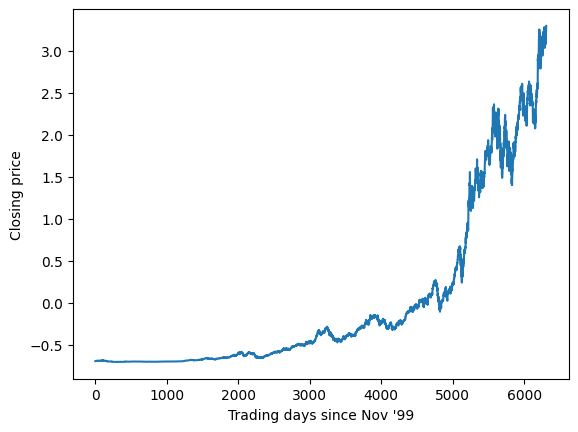

In [5]:
# Data Visualization
plt.xlabel('Trading days since Nov \'99')
plt.ylabel('Closing price')
days = []
closes = []
opens = []
for i in list(df.index):
    days.append(i)
    closes.append(df.loc[i, 'Close'])
plt.plot(days, closes)#, opens)
plt.show()
#Shows Close price over time

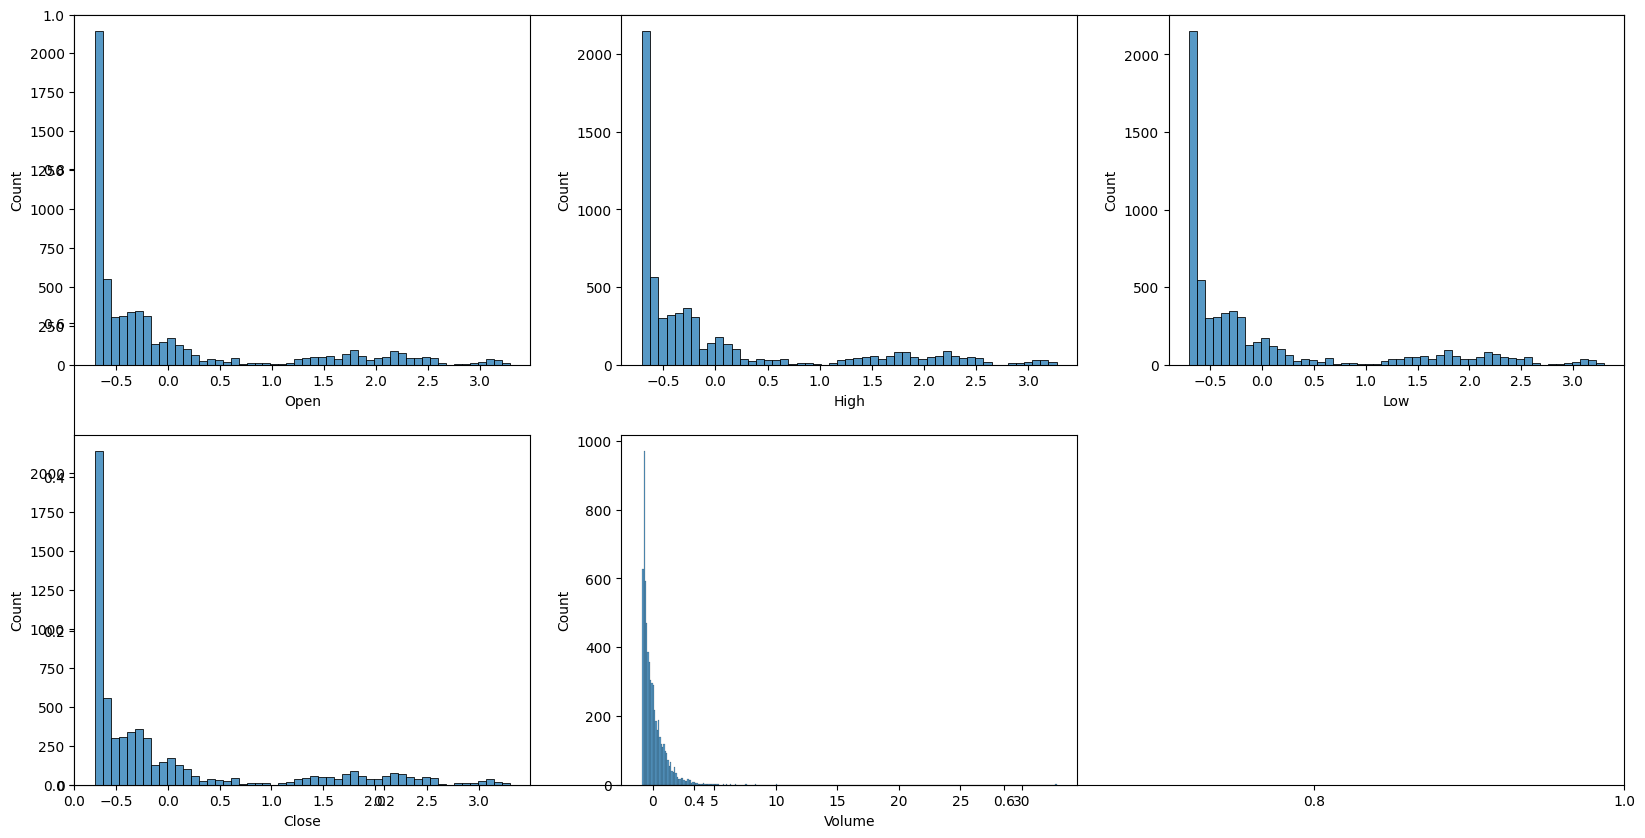

In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.histplot(df[col])
plt.show()

In [ ]:
# Data Preprocessing

dt = df['Date'].dt

df['Day'] = dt.day.astype('int')
df['Month'] = dt.month.astype('int')
df['Year'] = dt.year.astype('int')

df['Is_quarter_end'] = np.where(df['Month']%3==0,1,0)

df['Range'] = df['High'] - df['Low']
df['Change'] = df['Close'] - df['Open']

for period in [7,14,30]: # based on close; backfill for rolling avg
    df[f'MA_{period}'] = df['Close'].rolling(window=period).mean().bfill()
    


    

df.head(n=10)


,Date,Open,High,Low,Close,Volume,Day,Month,Year,Is_quarter_end,Range,Change,MA_7,MA_14,MA_30
0,1999-11-01,-0.692339,-0.692448,-0.692318,-0.692541,-0.290852,1,11,1999,0,-0.000130,-0.000203,-0.691380,-0.690977,-0.689825
1,1999-11-02,-0.692640,-0.692299,-0.692327,-0.692145,-0.016473,2,11,1999,0,0.000028,0.000495,-0.691380,-0.690977,-0.689825
2,1999-11-03,-0.692094,-0.692066,-0.691765,-0.691957,-0.177413,3,11,1999,0,-0.000301,0.000137,-0.691380,-0.690977,-0.689825
3,1999-11-04,-0.692028,-0.691750,-0.691823,-0.691638,-0.062292,4,11,1999,0,0.000073,0.000390,-0.691380,-0.690977,-0.689825
4,1999-11-05,-0.691642,-0.691302,-0.691308,-0.690931,0.023488,5,11,1999,0,0.000006,0.000711,-0.691380,-0.690977,-0.689825
5,1999-11-08,-0.691170,-0.689906,-0.690890,-0.689717,1.238084,8,11,1999,0,0.000984,0.001453,-0.691380,-0.690977,-0.689825
6,1999-11-09,-0.690172,-0.690388,-0.690699,-0.690734,0.915747,9,11,1999,0,0.000312,-0.000562,-0.691380,-0.690977,-0.689825
7,1999-11-10,-0.691095,-0.690574,-0.690681,-0.690460,0.389810,10,11,1999,0,0.000107,0.000635,-0.691083,-0.690977,-0.689825
8,1999-11-11,-0.690591,-0.690668,-0.690415,-0.690338,-0.310642,11,11,1999,0,-0.000254,0.000253,-0.690825,-0.690977,-0.689825
9,1999-11-12,-0.690538,-0.690761,-0.690795,-0.690583,-0.289757,12,11,1999,0,0.000035,-0.000045,-0.690629,-0.690977,-0.689825


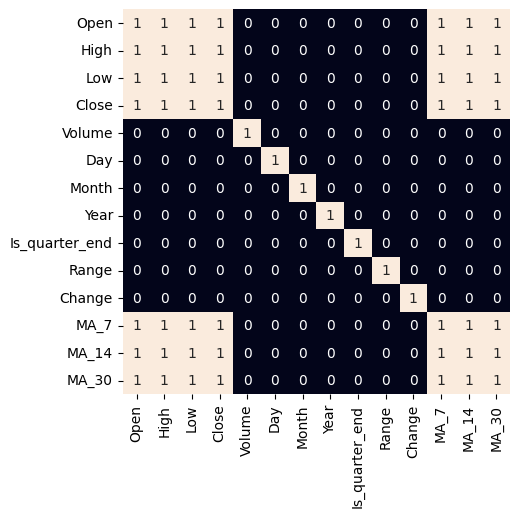

In [90]:
plt.figure(figsize=(5, 5)) 

sns.heatmap(df.drop('Date', axis=1).corr() > 0.99, annot=True, cbar=False)
plt.show()

#Identifies too high correlation

In [26]:
#Scale needed derived features
df[['Range', 'Change', 'MA_14']] = scaler.fit_transform(df[['Range', 'Change', 'MA_14']])
features = df[['Volume', 'Is_quarter_end', 'Range', 'Change', 'MA_14']] # Unique features
target = df['Close']

In [61]:
tscv = TimeSeriesSplit(max_train_size=None)

train_size = int(len(features) * 0.8)  # or use a more sophisticated splitting method
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]


In [ ]:
#Hyperparam tuning
param_spaces = {
    'Ridge': { 'alpha': [10**n for n in range(-3,5)] },
    
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost' : {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'n_estimators': [100, 500, 1000],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    },
    'AdaBoost':{
        'n_estimators': [50, 100, 200],       
        'learning_rate': [0.01, 0.1, 0.5, 1],  
        'loss': ['linear', 'square', 'exponential']  
    },
    'MLPRegressor':{
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)], 
        'activation': ['relu', 'tanh', 'logistic'],                  
        'solver': ['adam', 'lbfgs'],                               
        'alpha': [0.0001, 0.001, 0.01],                              
        'learning_rate_init': [0.001, 0.01, 0.1],                 
        'max_iter': [200, 500] 
    }
}


In [68]:
# Ridge Regression

ridge_params = param_spaces['Ridge']

ridge = Ridge()

mse_score = make_scorer(mse, greater_is_better=False)

search_ridge = GridSearchCV(estimator=ridge,
                         param_grid=ridge_params,
                         scoring=mse_score,
                         cv=tscv,
                         verbose=1)


search_ridge.fit(X_train, y_train)

print(f"Best parameters: {search_ridge.best_params_}")
print(f"Best score (negative MSE): {search_ridge.best_score_}")

opt_ridge = search_ridge.best_estimator_


prediction = opt_ridge.predict(X_test)

print(mse(y_test, prediction))
diff = y_test - prediction






Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'alpha': 0.001}
Best score (negative MSE): -0.00013394864013492965
0.00676024503549692


In [74]:
rf_params = param_spaces['RandomForest']

rf = RandomForestRegressor()

search_rf = GridSearchCV(estimator=rf,
                         param_grid=rf_params,
                         scoring=mse_score,
                         cv=tscv,
                         verbose=1)


search_rf.fit(X_train, y_train)

print(f"Best parameters: {search_rf.best_params_}")
print(f"Best score (negative MSE): {search_rf.best_score_}")

opt_rf = search_rf.best_estimator_


prediction = opt_rf.predict(X_test)

diff = prediction - y_test

print(mse(y_test, prediction))
# Data Visualization
#Shows Close price over time
#Best is n_estimators=50, min_samples_split=2, max_depth=30; curr MSE = -.01587466


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 50}
Best score (negative MSE): -0.01593920512465111
2.522997582939121


In [77]:
#XGBoost Model
xgb_params = param_spaces['XGBoost']

xgbr = xgb.XGBRegressor()

search_xgb = GridSearchCV(estimator=xgbr,
                         param_grid=xgb_params,
                         scoring=mse_score,
                         cv=tscv,
                         verbose=1)


search_xgb.fit(X_train, y_train)

print(f"Best parameters: {search_xgb.best_params_}")
print(f"Best score (negative MSE): {search_xgb.best_score_}")

opt_xgbr = search_xgb.best_estimator_


prediction = opt_xgbr.predict(X_test)

diff = prediction - y_test

print(mse(y_test, prediction))
# Data Visualization
#Shows Close price over time
#Best is n_estimators=100, min_samples_split=2, max_depth=20; curr MSE = -.189



Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.9}
Best score (negative MSE): -0.015754001168388737
2.6588827127223733


In [82]:
#AdaBoost Model

adb_params = param_spaces['AdaBoost']

adb = AdaBoostRegressor()

search_adb = GridSearchCV(estimator=adb,
                         param_grid=adb_params,
                         scoring=mse_score,
                         cv=tscv,
                         verbose=1)


search_adb.fit(X_train, y_train)

print(f"Best parameters: {search_adb.best_params_}")
print(f"Best score (negative MSE): {search_adb.best_score_}")

opt_adb = search_adb.best_estimator_


prediction = opt_adb.predict(X_test)

diff = prediction - y_test

print(mse(y_test, prediction))
# Data Visualization
#Shows Close price over time
#Best is n_estimators=100, min_samples_split=2, max_depth=20; curr MSE = -.189




Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 1, 'loss': 'square', 'n_estimators': 50}
Best score (negative MSE): -0.017168861272815288
2.5660390683085863


In [83]:
#MLPRegressor Model

mlp_params = param_spaces['MLPRegressor']

mlp = MLPRegressor()

search_mlp = GridSearchCV(estimator=mlp,
                         param_grid=mlp_params,
                         scoring=mse_score,
                         cv=tscv,
                         verbose=1)


search_mlp.fit(X_train, y_train)

print(f"Best parameters: {search_mlp.best_params_}")
print(f"Best score (negative MSE): {search_mlp.best_score_}")

opt_mlp = search_mlp.best_estimator_


prediction = opt_mlp.predict(X_test)

diff = prediction - y_test

print(mse(y_test, prediction))
# Data Visualization
#TODO: run; record final result



Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}
Best score (negative MSE): -0.0003306228442449599
0.17670061025062167


{'AdaBoost': [AdaBoostRegressor(learning_rate=1, loss='square'), 2.5721204253325656], 'Ridge': [Ridge(alpha=0.001), 0.00676024503549692], 'XGBoost': [XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 2.6588827127223733], 'Random Forest': [RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=5

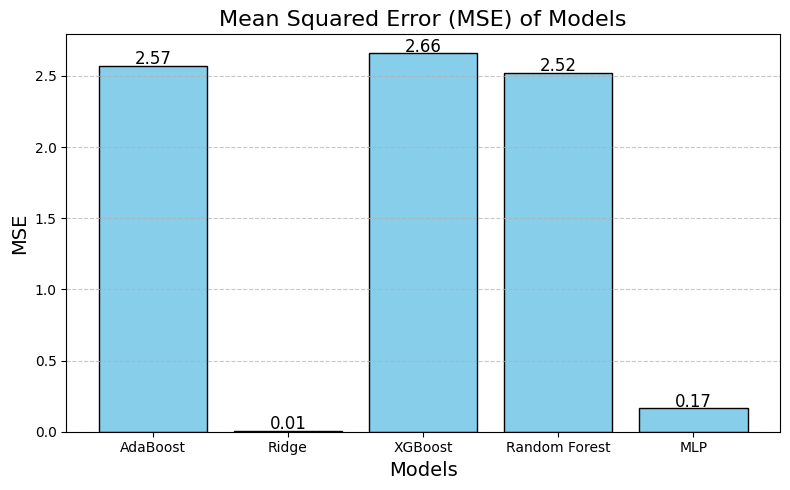

In [ ]:
#TODO: run this; make sure its nice

models = {
    'AdaBoost': [opt_adb],
    'Ridge': [opt_ridge],
    'XGBoost': [opt_xgbr],
    'Random Forest': [opt_rf],
    'MLP': [opt_mlp]
}

for model_name, li in models.items():
    
    model = li[0]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    models[model_name].append( mse(y_test, y_pred))




model_names = list(models.keys())
mses = [li[1] for li in models.values()]  # Extract the MSE values
print(model_names)
print(mses)

print()

plt.figure(figsize=(8, 5))
plt.bar(model_names, mses, color='skyblue', edgecolor='black')

plt.title('Mean Squared Error (MSE) of Models', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('MSE', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, mse_val in enumerate(mses):
    plt.text(i, mse_val + 0.01, f'{mse_val:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()
